In [1]:
from _utils import *

folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:80, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:80, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

pca = PCA(n_components=None)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

2024-10-14 13:05:18.358901: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-14 13:05:18.402016: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
all_maps_pca = np.concatenate((esc_maps_pca, cnc_maps_pca), axis=0)

In [3]:
esc_maps_pca.shape

(1225, 2982)

In [5]:
cnc_maps_pca.shape

(1757, 2982)

In [24]:
# Find range of coordinates in all PCs
min_coords = np.min(all_maps_pca, axis=0)
max_coords = np.max(all_maps_pca, axis=0)

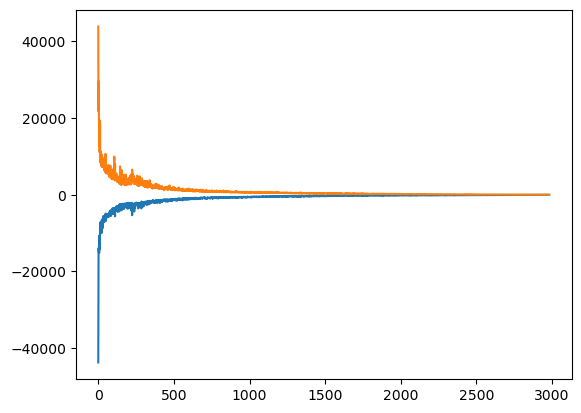

In [28]:
plt.plot(min_coords, label='min')
plt.plot(max_coords, label='max')

(0.01, 1000000.0)

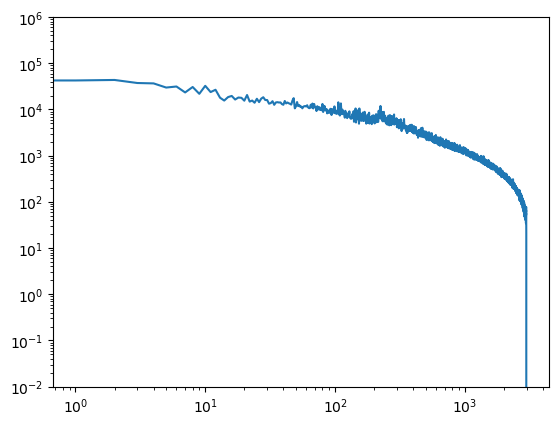

In [129]:
plt.loglog(max_coords - min_coords, label='range')
plt.ylim(1e-2, 1e6)

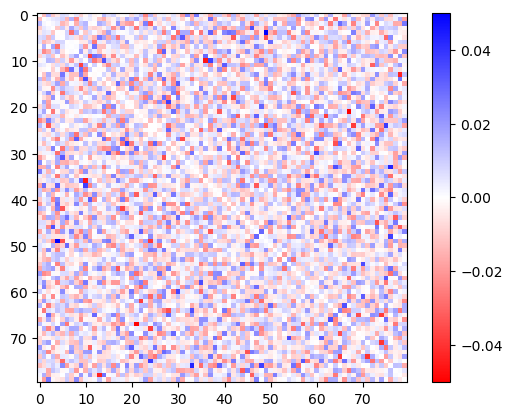

In [86]:
plt.imshow(pca.components_[2000].reshape(80, 80), cmap='bwr_r', vmin=-0.05, vmax=0.05)
plt.colorbar()

In [18]:
rep_coord = np.ones_like(esc_maps_pca[0, :]) * 50

In [19]:
rep_map = pca.inverse_transform(rep_coord)

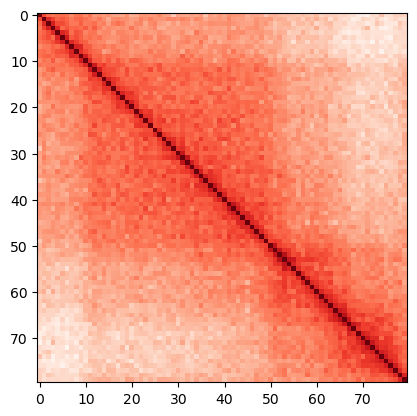

In [20]:
plt.imshow(rep_map.reshape(80, 80), cmap='Reds_r')

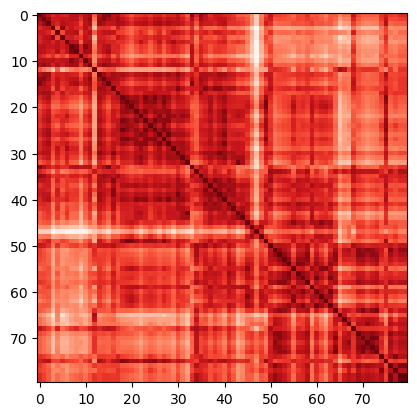

In [17]:
plt.imshow(esc_maps_interp[0], cmap='Reds_r')

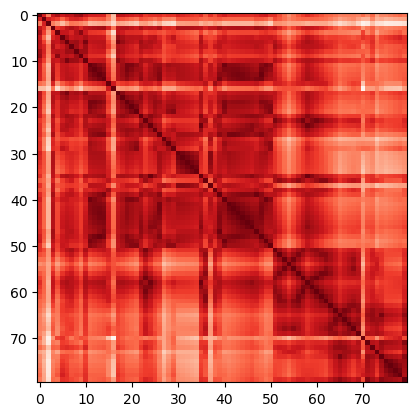

In [120]:
plt.imshow(pca.inverse_transform(esc_maps_pca[1, :]).reshape(80, 80), cmap='Reds_r')

In [121]:
rank = 20
truncated_map_pca = np.zeros_like(esc_maps_pca[1, :])
truncated_map_pca[:rank] = esc_maps_pca[0, :rank]
truncated_map_pca[rank:] = np.mean(esc_maps_pca[:, rank:], axis=0)

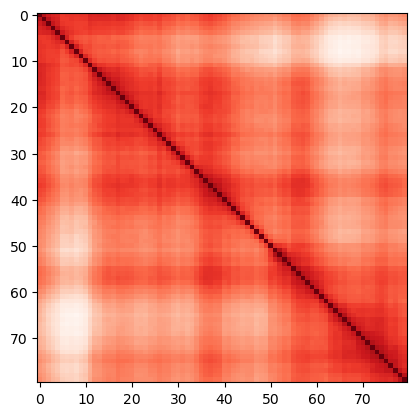

In [122]:
plt.imshow(pca.inverse_transform(truncated_map_pca).reshape(80, 80), cmap='Reds_r')

In [104]:
rank_list = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 2982]
truncated_map_list = []
error_list = []
eigenvector_list = []
for rank in rank_list:
    truncated_map_pca = np.zeros_like(esc_maps_pca[0, :])
    truncated_map_pca[:rank] = esc_maps_pca[0, :rank]
    truncated_map_list.append(pca.inverse_transform(truncated_map_pca).reshape(80, 80))
    error_list.append(np.linalg.norm(esc_maps_interp[0] - truncated_map_list[-1]))
    eigenvector_list.append(pca.components_[rank - 1].reshape(80, 80))

In [106]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20241014'

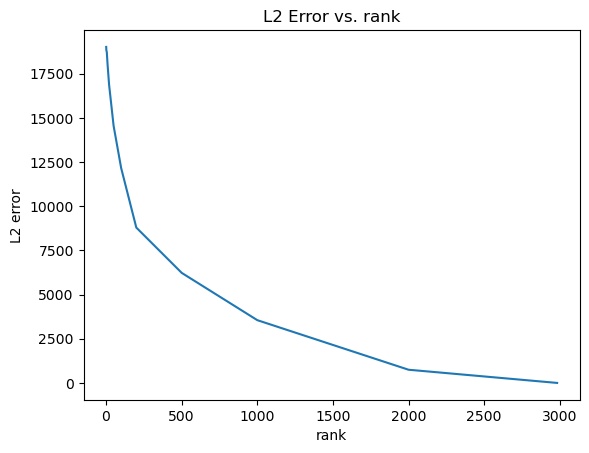

In [107]:
plt.plot(rank_list, error_list)
plt.title('L2 Error vs. rank')
plt.xlabel('rank')
plt.ylabel('L2 error')
plt.savefig(save_dir + '/l2_error_vs_rank.png', dpi=300, bbox_inches='tight')

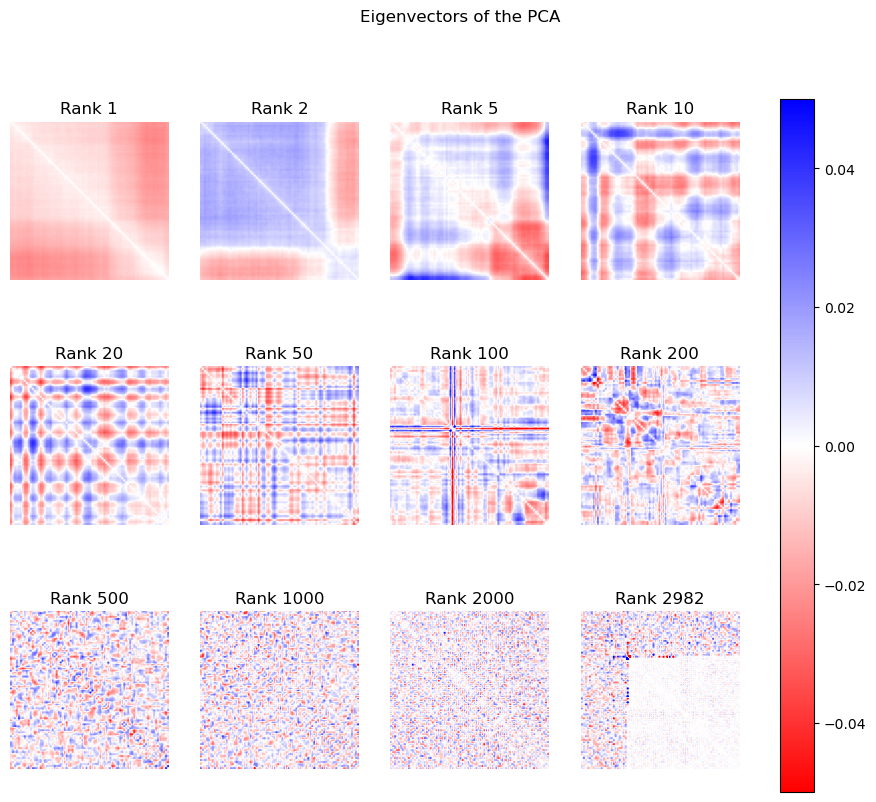

In [114]:
# There are 12 eigenvectors
# plot them in a 3x4 grid

import matplotlib


fig, axs = plt.subplots(3, 4, figsize=(12, 9))
for i in range(12):
    axs[i // 4, i % 4].imshow(eigenvector_list[i], cmap='bwr_r', vmin=-0.05, vmax=0.05)
    axs[i // 4, i % 4].axis('off')
    axs[i // 4, i % 4].set_title(f'Rank {rank_list[i]}')
# Add the colorbar
fig.subplots_adjust(right=0.8)
fig.colorbar(matplotlib.cm.ScalarMappable(cmap='bwr_r', norm=matplotlib.colors.Normalize(vmin=-0.05, vmax=0.05)), ax=axs, orientation='vertical', fraction=0.05, pad=0.05)
fig.suptitle('Eigenvectors of the PCA')
fig.savefig(save_dir + '/eigenvectors.png', dpi=300, bbox_inches='tight')

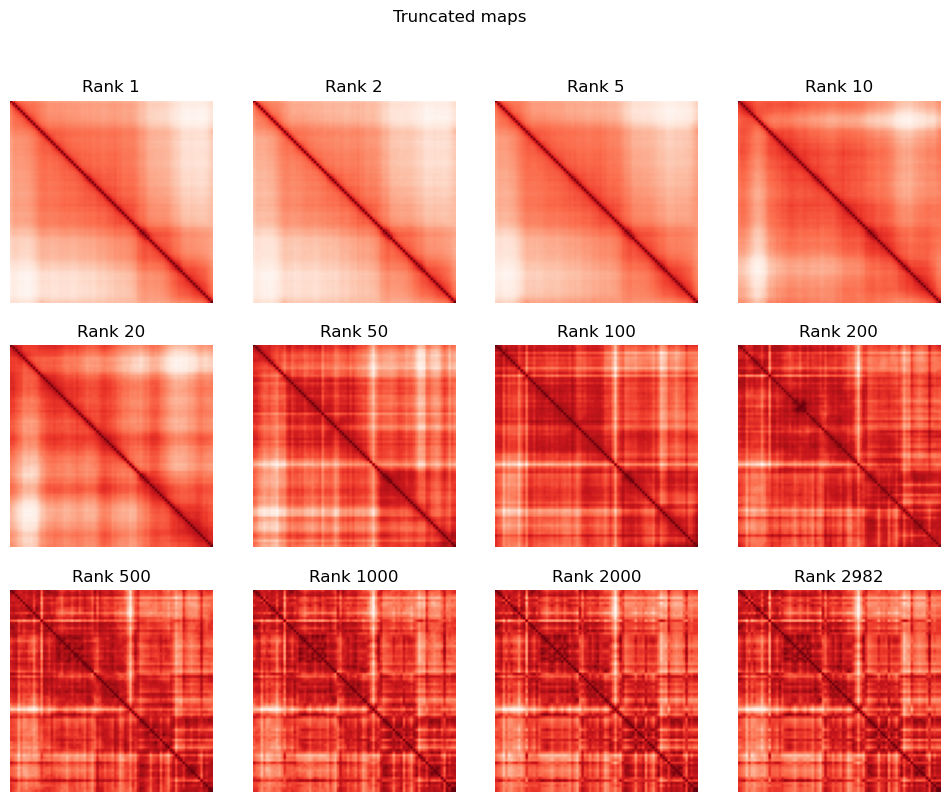

In [117]:
# Plot the truncated maps
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
for i in range(12):
    axs[i // 4, i % 4].imshow(truncated_map_list[i], cmap='Reds_r')
    axs[i // 4, i % 4].axis('off')
    axs[i // 4, i % 4].set_title(f'Rank {rank_list[i]}')
fig.suptitle('Truncated maps')
fig.savefig(save_dir + '/truncated_maps.png', dpi=300, bbox_inches='tight')

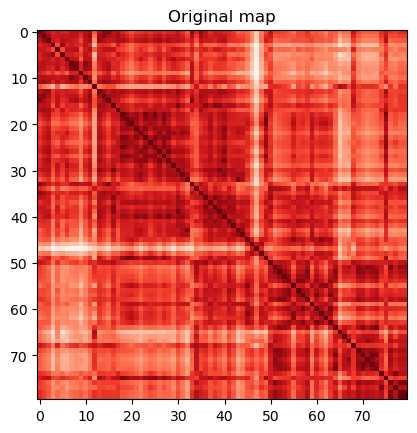

In [119]:
# Plot the original map
plt.imshow(esc_maps_interp[0], cmap='Reds_r')
plt.title('Original map')
plt.savefig(save_dir + '/original_map.png', dpi=300, bbox_inches='tight')

In [98]:
from sklearn.metrics.pairwise import euclidean_distances

In [99]:
diss = euclidean_distances(all_maps_interp_flat)

In [100]:
np.mean(diss)

32110.37090435507

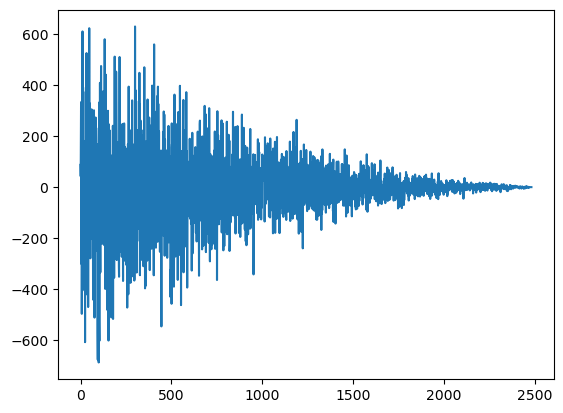

In [83]:
plt.plot(esc_maps_pca[0, 500:])